## MSCFE 650 GROUP 3-B SUBMISSION 1 - DATA ANALYSIS AND PREPARATION.

### Group Members:

1. Gam Dieudonne Kimal
2. Joe Frank
3. Eniola Igunnu
4. Ndenge Gerald Atumu

## INTRODUCTION

In this exercise we will prepare and analyze a timeseries data ( google stock ) from Yahoo finance for a 5 year period ending 2019-12-31. We will be applying data preparation techniques from econometrics and statistics by implementing the statistical tools and measures listed below with the objective of understanding the characteristics of the observed data:

1. Mean and Standard deviation
2. Technical indicators (Moving Average, EWMA)
3. structural breaks
4. Bera-Jarque test for returns
5. Cointegration test. 
6. Forecast next period (t+1) asset return evolution using AR(1) model
7. Line charts


#### *Loading neccesary modules*

In [2]:
import yfinance as yf # Get data from web
import pandas as pd # tables and data manipulation
import numpy as np # vectors and matrices
import matplotlib.pyplot as plt # plots
%matplotlib inline
import matplotlib as mpl
from matplotlib import style
from scipy import stats # Statistics and econometrics
from statsmodels.tsa.vector_ar.vecm import coint_johansen # Cointergration test
from fbprophet import Prophet # Forcasting
from statsmodels.tsa.arima_model import ARMA # Timeseries analysis
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt\


#### *Loading Google data*

In [7]:
goog = yf.download('GOOG', start = '2015-01-01', end = '2019-12-31')

print(goog.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-12-31  529.795471  531.141724  524.360352  524.958740  524.958740   
2015-01-02  527.561584  529.815369  522.665039  523.373108  523.373108   
2015-01-05  521.827332  522.894409  511.655243  512.463013  512.463013   
2015-01-06  513.589966  514.761719  499.678131  500.585632  500.585632   
2015-01-07  505.611847  505.855164  498.281952  499.727997  499.727997   

             Volume  
Date                 
2014-12-31  1368200  
2015-01-02  1447500  
2015-01-05  2059800  
2015-01-06  2899900  
2015-01-07  2065000  


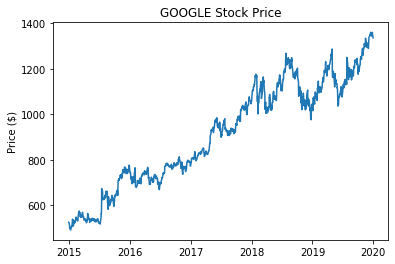

In [5]:
# Plotting the adjusted close of our stock info
plt.plot(goog.index, goog['Adj Close'])
plt.title('GOOGLE Stock Price')
plt.ylabel('Price ($)');
plt.show()

Already we can observe a rise in the stock price of google over the years with some very noticeable up and downward swings between 2018 and 2019

## A. Mean and Standard Deviation
For better analysis we will calculate the mean and standard deviation of Google stock returns for the period under consideration. We will first calculate the daily stock returns and apply the mean and standard deviation formula to it.


Date
2014-12-31         NaN
2015-01-02   -0.003020
2015-01-05   -0.020846
2015-01-06   -0.023177
2015-01-07   -0.001713
Name: Adj Close, dtype: float64


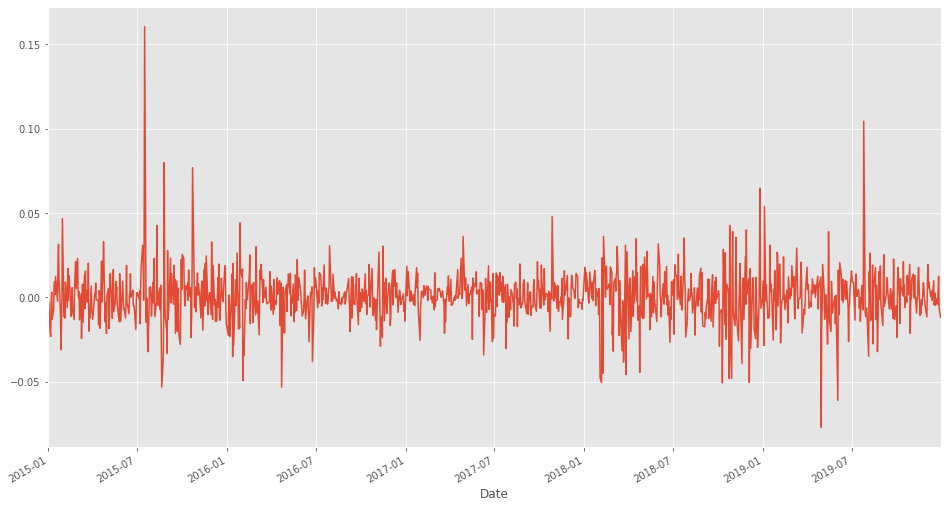

In [57]:
# calculating daily returns
goog_returns = goog['Adj Close'].pct_change()
goog_returns.plot(label='return')
print(goog_returns.head())

In [17]:
# calculating the mean
print("Mean = " , goog_returns.mean())

# calculating the Std
print("std = " , goog_returns.std())

Mean =  0.0008566461156084906
std =  0.015122035562298804


## B. Moving Average and EWMA

Here, we will calculate the simple and exponential moving averages using Pandas. We will use the rolling function with a window of 100. To be able to compare the EWMA with the Simple Moving Average (SMA) we will use a span value.

In [32]:
#Calculating Moving Average
goog_cl = goog['Adj Close']
goog_sma1 = goog_cl.rolling(window=25).mean()
goog_sma2 = goog_cl.rolling(window=100).mean()
print(goog_sma.tail())

Date
2019-12-23    1250.500504
2019-12-24    1251.996205
2019-12-26    1254.077006
2019-12-27    1255.896406
2019-12-30    1257.517906
Name: Adj Close, dtype: float64


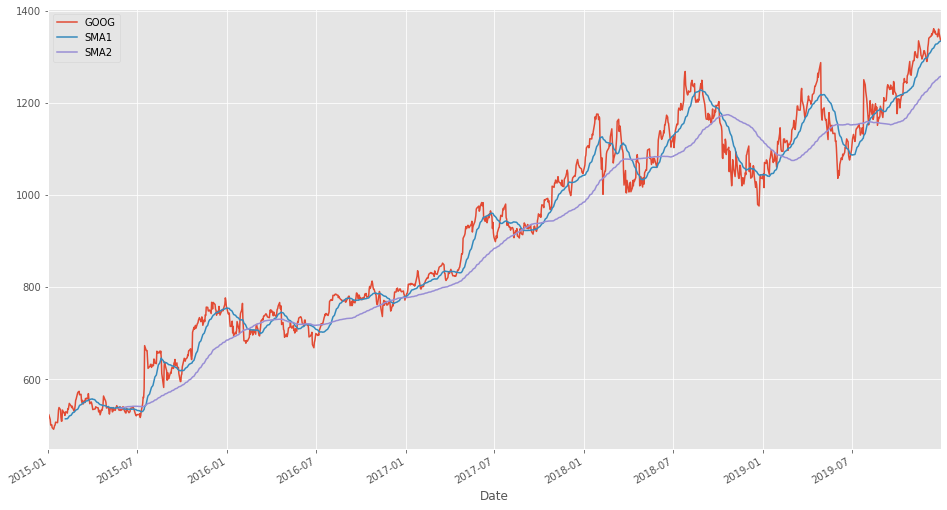

In [33]:
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

goog_cl.plot(label='GOOG')
goog_sma1.plot(label='SMA1')
goog_sma2.plot(label='SMA2')
plt.legend()

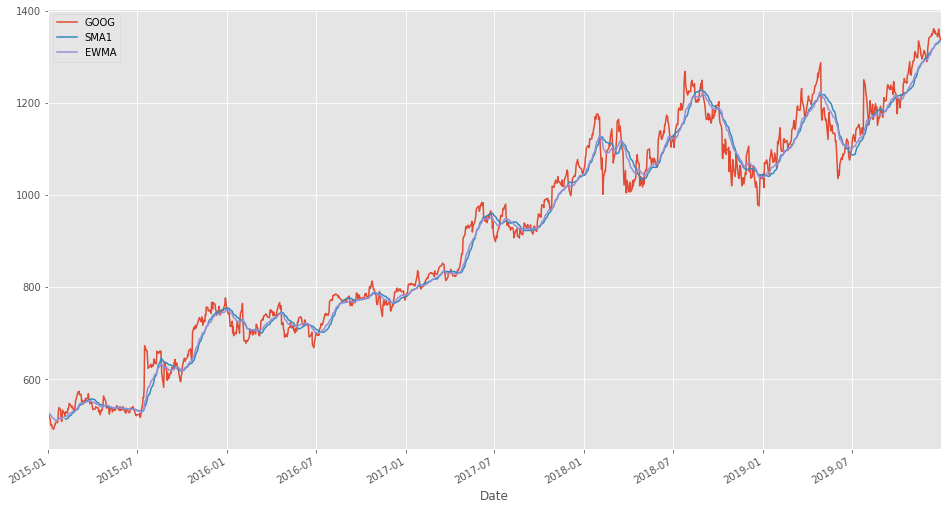

In [35]:
#Calculating EWMA
goog_ewma = goog_cl.ewm(span=25, adjust=False).mean()

goog_cl.plot(label='GOOG')
goog_sma1.plot(label='SMA1')
goog_ewma.plot(label='EWMA')
plt.legend()

## C. Structural breaks

We will use the prophet module to model and fit the data and which will by default create 25 change points into the initial 80% of our data-set. However, we will alter the change points to 10.

In [22]:
# Initialising the data
New_goog = goog.reset_index().rename(columns={'Date':'ds', 'Adj Close':'y'})
New_goog['y'] = np.log(New_goog['y'])

print(New_goog.head())

          ds        Open        High         Low       Close         y  \
0 2014-12-31  529.795471  531.141724  524.360352  524.958740  6.263320   
1 2015-01-02  527.561584  529.815369  522.665039  523.373108  6.260295   
2 2015-01-05  521.827332  522.894409  511.655243  512.463013  6.239229   
3 2015-01-06  513.589966  514.761719  499.678131  500.585632  6.215779   
4 2015-01-07  505.611847  505.855164  498.281952  499.727997  6.214064   

    Volume  
0  1368200  
1  1447500  
2  2059800  
3  2899900  
4  2065000  


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


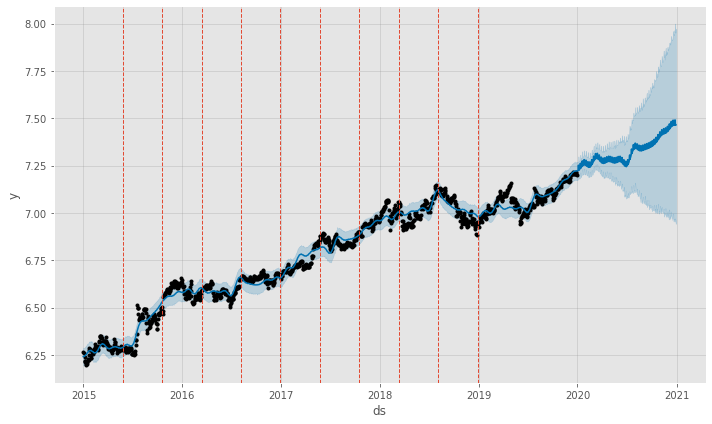

In [23]:
#creating the changepoints
model = Prophet(n_changepoints=10)
model.fit(New_goog);
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

#viewing the changepoints
model.changepoints

#plotting the changepoints
figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

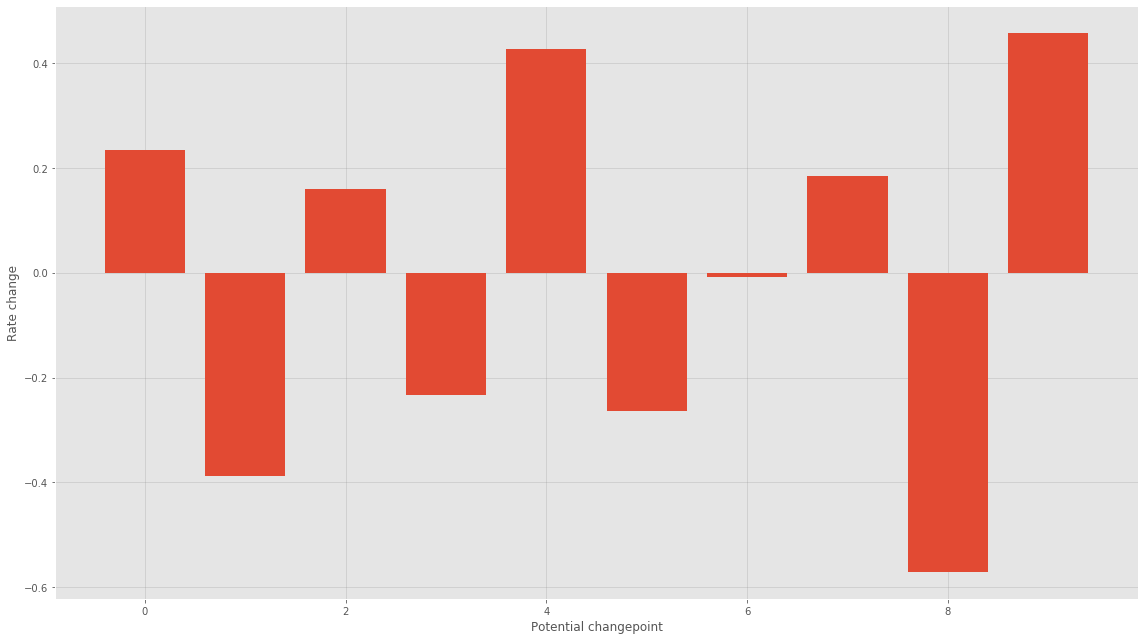

In [24]:
# Checking the magnitude of the change points

deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

## D. Jarque-Bera test


In [39]:
#Calculating jarque_bera 
print('Test Statistics (Jarque-Bera):')
print('Ajust Cl:', stats.jarque_bera(goog_cl.dropna()))


Test Statistics (Jarque-Bera):
Ajust Cl: (74.55760710175025, 1.1102230246251565e-16)


## E. Co-intergration test

Here we will test co-intergration between google stock and NVIDIA using Johansen test from statsmodel model

In [40]:
#getting NVIDIA Stock
nvda = yf.download('NVDA','2015-01-01','2019-12-31')

nvda_cl = nvda['Adj Close']

#merging both stocks for the test
goog_nvda = pd.DataFrame({'x':goog_cl,'y':nvda_cl})

[*********************100%***********************]  1 of 1 completed


In [47]:
#conducting the test
print ('Eigenvalues of VECM coefficient matrix',coint_johansen (goog_nvda,0,1).eig)
print ('Critical values (90%, 95%, 99%) of trace statistic',coint_johansen (goog_nvda,0,1).cvt)
print ('Trace statistic',coint_johansen (goog_nvda,0,1).lr1)
print ('Maximum eigenvalue statistic',coint_johansen (goog_nvda,0,1).lr2)

Eigenvalues of VECM coefficient matrix [0.00496782 0.00046732]
Critical values (90%, 95%, 99%) of trace statistic [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Trace statistic [6.84223116 0.58709336]
Maximum eigenvalue statistic [6.2551378  0.58709336]


## F. Forcasting t+1 of our stock

We will first estimate our data to understand the estimation routine before applying it to our data using statsmodels for the forcasting


In [48]:
#Estimating our data
# Fit an AR(1) model to the first simulated data
mod = ARMA(goog_cl, order=(1,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print("When the true phi=0.9, the estimate of phi (and the constant) are:")
print(res.params)


C:\Users\gerard.ndenge\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:                     ARMA(1, 0)   Log Likelihood               -5106.809
Method:                       css-mle   S.D. of innovations             13.986
Date:                Tue, 25 Feb 2020   AIC                          10219.619
Time:                        17:57:56   BIC                          10235.030
Sample:                             0   HQIC                         10225.411
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             922.5109    256.217      3.601      0.000     420.334    1424.687
ar.L1.Adj Close     0.9991      0.001    952.964      0.000       0.997       1.001
                                

C:\Users\gerard.ndenge\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\gerard.ndenge\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\gerard.ndenge\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


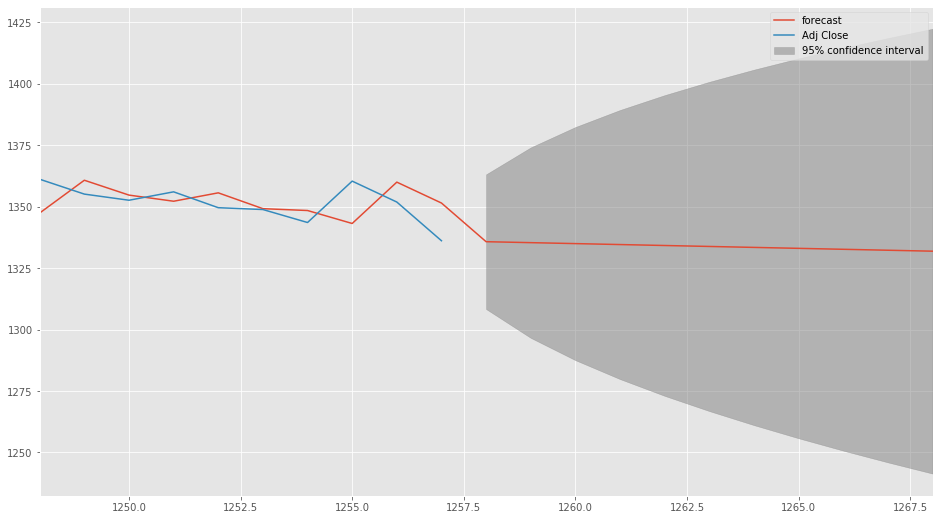

In [50]:
# Forecast the first AR(1) model
mod = ARMA(goog_cl, order=(1,0))
res = mod.fit()
res.plot_predict(start=1248, end=1268)
plt.show()

## Forcasting Method 2

In [51]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
# split dataset
X = goog_cl.values #.dropna()
train, test = X[1:len(X)-21], X[len(X)-5:] # Since we have 5 Trading days in a week
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [52]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=1316.469116, expected=1348.839966
predicted=1348.118807, expected=1343.560059
predicted=1338.970236, expected=1360.400024
predicted=1361.346412, expected=1351.890015
predicted=1349.512694, expected=1336.140015
Test MSE: 359.228


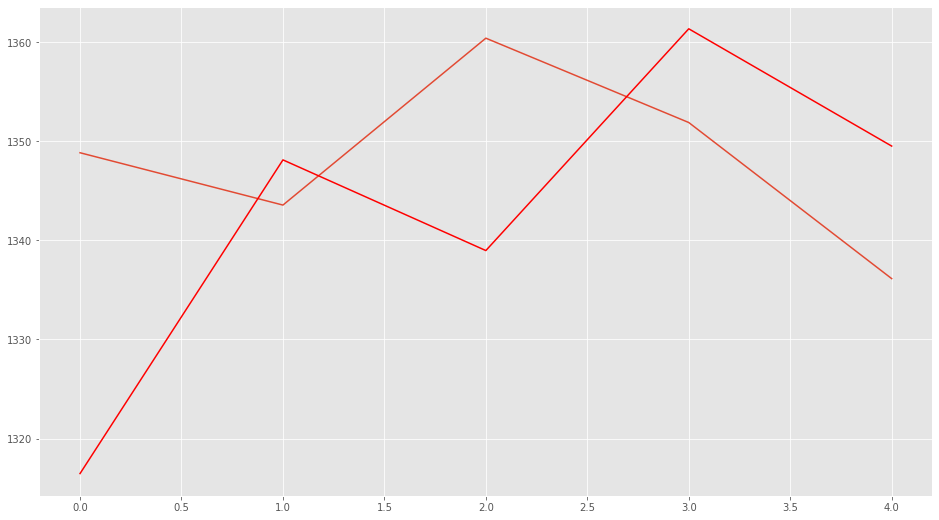

In [54]:
# plot
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [56]:
values = DataFrame(goog_cl.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.998166
t+1  0.998166  1.000000
